## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import warnings
import os
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'

os.chdir(work_dir)


In [2]:
! pip install -r requirements.txt

In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

In [6]:
crypto.binance_client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'updateTime': 1651961431781,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locke

### Generate Candles and build features from technical analysis

In [7]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [8]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

670

,Close,Pred Close
Date,,
2022-05-12 07:00:00,27131.10,27135.693653
2022-05-12 07:15:00,28273.10,27133.147077
2022-05-12 07:30:00,28221.29,26952.994837
2022-05-12 07:45:00,28193.40,26692.533806
2022-05-12 08:00:00,28231.28,26665.552540
...,...,...
2022-07-02 19:30:00,19238.03,19503.586119
2022-07-02 19:45:00,19273.27,19485.674984
2022-07-02 20:00:00,19246.35,19480.513094


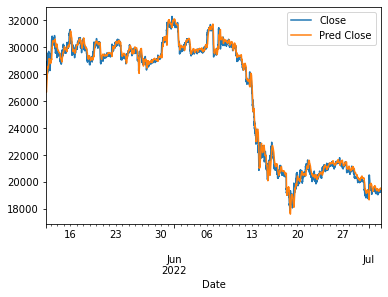

In [10]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

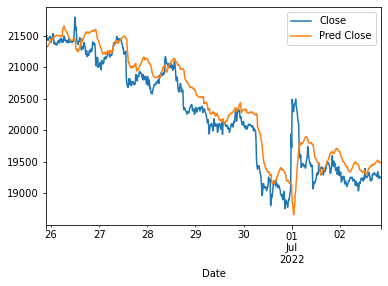

In [11]:
df_preds_true.iloc[-new_time_steps:].dropna().plot()


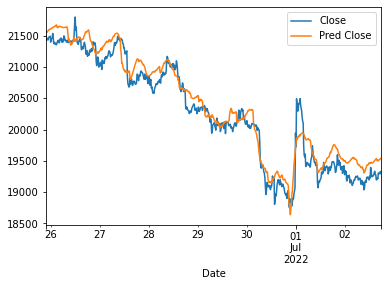

In [31]:
df_preds_shifted_true = tu.merge_true_preds(can_btc.candles, preds, period=-15+1)
df_preds_shifted_true.iloc[-new_time_steps:].dropna().plot()


Initial time 2022-06-25 22:00:00
Final time 2022-07-02 21:00:00
Fee: 0.025
----------------------
Buy      456 ( 257 ok 199 ko )
Avg PCT gain: 1.0022983815827184
Avg PCT loss: 0.9979941565725167
Wins  PCT   0.5635964912280702
Avg PCT Gain.    1.0022983815827184
No-op    0
Wallet   3282.4460000000195
Drawback -369.3587499999985
Kelly Fraction    0.1290670540215657
Total earned 3282.4460000000195


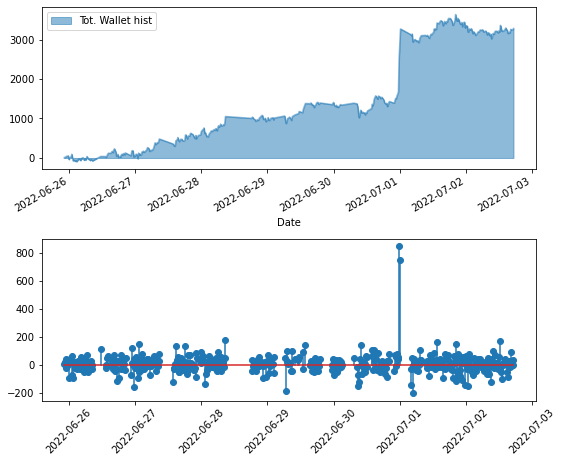

In [32]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 15,
                                                    long_short = "long", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)


In [14]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    time.sleep(min_till_close*dt_unit + 1)


In [15]:
crypto_test.binance_client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1656783969070,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00300000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '9941.68210000', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [16]:
# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025

total_wallet_history = []
single_wallet_history = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []
time_close_order_history = []

buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], '15m', '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = "15m",
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test = False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(10,delta_date)

    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]

    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/10.) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001
            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)

            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed at {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = est_close_time - current_time
                time.sleep(60)

                if 1 < (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())
                    profit = filled_close_price - filled_open_price
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], '15m', '15').index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True
                    
        else:
            old_profit_negative = False
            old_profits = 0
            prev_close_date = getminutedata(
                crypto.binance_client, tickers[0], '15m', '15').index[-1]
            



                                                         



Current Time: 2022-07-02 20:45:45.525069
Minutes till Next Close: 14.25
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-02 21:00:32.655941
Minutes till Next Close: 14.466666666666667
-----------------------------------
Order filled at 2022-07-02 21:00:33.994085
Order will be closed at 2022-07-02 21:15:00
Filled open price: 19263.3
Previous close price: 19268.48
Predicted close price: 19540.439458099


KeyboardInterrupt: 

In [ ]:
prev_close_date = getminutedata(crypto.binance_client, tickers[0], '15m', '15')
prev_close_date.index

In [ ]:
df_preds_true_shifted.iloc[-20:]